## DSC 672 Data science Capstone project

Depaul University

Group 7: 
<br>Peter Sarkis, DePaul University, School of Computing, psarkis@depaul.edu
<br>Thejus Kannoth, DePaul University, School of Computing, tkannoth@depaul.edu
<br>Matthew Smolzer, DePaul University, School of Computing, msmolzer@depaul.edu
<br>Mounika Munigala, DePaul University, School of Computing, mmunigal@depaul.edu 


Chicago, IL

### Project Description

In this project we will be analyzing injury risk based on the features.

Data Source: https://www.kaggle.com/datasets/icliu30/nba-player-stats-and-injured-data-from-13-to-23

### Import Libraries


In [242]:
# Data Manipulation and Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Handling Class Imbalance
from imblearn.over_sampling import SMOTE

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint

# Feature Selection
from sklearn.feature_selection import RFE

# Advanced Models
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier


### Get the data

In [244]:
# Load the uploaded Excel file
file_path = 'nba_injured_players.xlsx'
data = pd.ExcelFile(file_path)

In [245]:
# Display sheet names to understand the structure of the file
data.sheet_names

['Sheet1']

In [246]:
# Load the data from the first sheet
df = data.parse('Sheet1')

# Display the first few rows to understand the structure of the dataset
df.head()


,PLAYER_ID,PLAYER_NAME,SEASON,SEASON_NUM,AGE,PLAYER_HEIGHT_INCHES,PLAYER_WEIGHT,GP,MIN,USG_PCT,...,AVG_SEC_PER_TOUCH,AVG_DRIB_PER_TOUCH,ELBOW_TOUCHES,POST_TOUCHES,PAINT_TOUCHES,TEAM,INJURED.ON,RETURNED,DAYS.MISSED,INJURED_TYPE
0,203932,Aaron Gordon,22-23,22.5,27,80,235,61,30.1,0.206,...,2.94,2.11,1.8,2.1,6.8,Nuggets,2023-02-02,2023-02-07,5,Sprained_ankle
1,1630174,Aaron Nesmith,22-23,22.5,23,77,215,66,24.6,0.170,...,1.67,0.80,0.4,0.0,1.1,Pacers,2022-12-23,2022-12-26,3,Sprained_ankle
2,1629014,Anfernee Simons,22-23,22.5,23,75,181,62,35.0,0.247,...,4.78,4.18,0.3,0.0,0.6,Blazers,2023-02-16,2023-03-01,13,Sprained_ankle
3,1627732,Ben Simmons,22-23,22.5,26,82,240,42,26.3,0.142,...,3.42,2.35,2.3,1.1,4.0,Nets,2023-01-26,2023-02-07,12,Sore_knee
4,1627732,Ben Simmons,22-23,22.5,26,82,240,42,26.3,0.142,...,3.42,2.35,2.3,1.1,4.0,Nets,2022-10-31,2022-11-07,7,Knee_injury


### Convert Date Columns

In [248]:
# Convert Dates
df['INJURED.ON'] = pd.to_datetime(df['INJURED.ON'])
df['RETURNED'] = pd.to_datetime(df['RETURNED'])

### Summary Statistics and Missing Values Handling

In [250]:
# Summary statistics for numeric columns
summary_statistics = df.describe()
print(" Summary statistics \n ", summary_statistics)

 Summary statistics 
            PLAYER_ID   SEASON_NUM          AGE  PLAYER_HEIGHT_INCHES  \
count  1.214000e+03  1214.000000  1214.000000           1214.000000   
mean   7.845084e+05    19.278418    26.687809             78.896211   
min    2.037000e+03    13.500000    19.000000             70.000000   
25%    2.023300e+05    17.500000    23.000000             76.000000   
50%    2.038990e+05    19.500000    26.000000             79.000000   
75%    1.628377e+06    21.500000    30.000000             82.000000   
max    1.631110e+06    22.500000    39.000000             89.000000   
std    7.099509e+05     2.220974     4.132859              3.500903   

       PLAYER_WEIGHT           GP          MIN      USG_PCT         PACE  \
count    1214.000000  1214.000000  1214.000000  1214.000000  1214.000000   
mean      219.747117    55.697694    25.148023     0.202437   100.240041   
min       169.000000     1.000000     1.000000     0.026000    91.030000   
25%       200.000000    46.000000

In [251]:
# Handling Missing Values
df.replace([' None', ''], np.nan, inplace=True)
df.dropna(inplace=True)

### Encode Categorical Variables

In [253]:
# Ensure all columns are numerical before scaling
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = pd.factorize(df[col])[0]

In [254]:
# Encoding Categorical Variables
le = LabelEncoder()
df['TEAM'] = le.fit_transform(df['TEAM'])
df['INJURED_TYPE'] = le.fit_transform(df['INJURED_TYPE'])


In [255]:
drop_cols = ['PLAYER_NAME', 'INJURED.ON', 'RETURNED', 'PLAYER_ID', 'SEASON']
df.drop(columns=drop_cols, inplace=True)

### Exploratory Data Analysis (EDA)

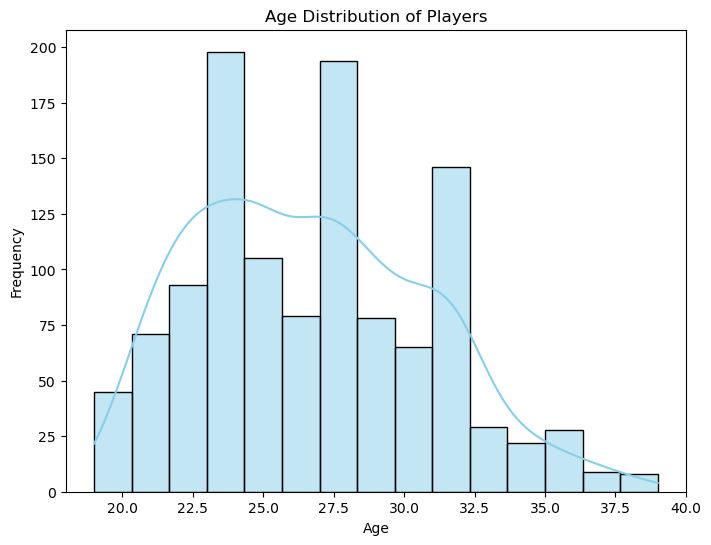

In [257]:
# Exploratory Data Analysis (EDA)
plt.figure(figsize=(8,6))
sns.histplot(df['AGE'], bins=15, kde=True, color='skyblue', edgecolor='black')
plt.title('Age Distribution of Players')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

This histogram visualizes the age distribution of NBA players with a kernel density estimate (KDE) overlay. The plot shows that most players are between 22 and 30 years old, with a peak around 23 and 27 years, indicating that younger athletes dominate the league.

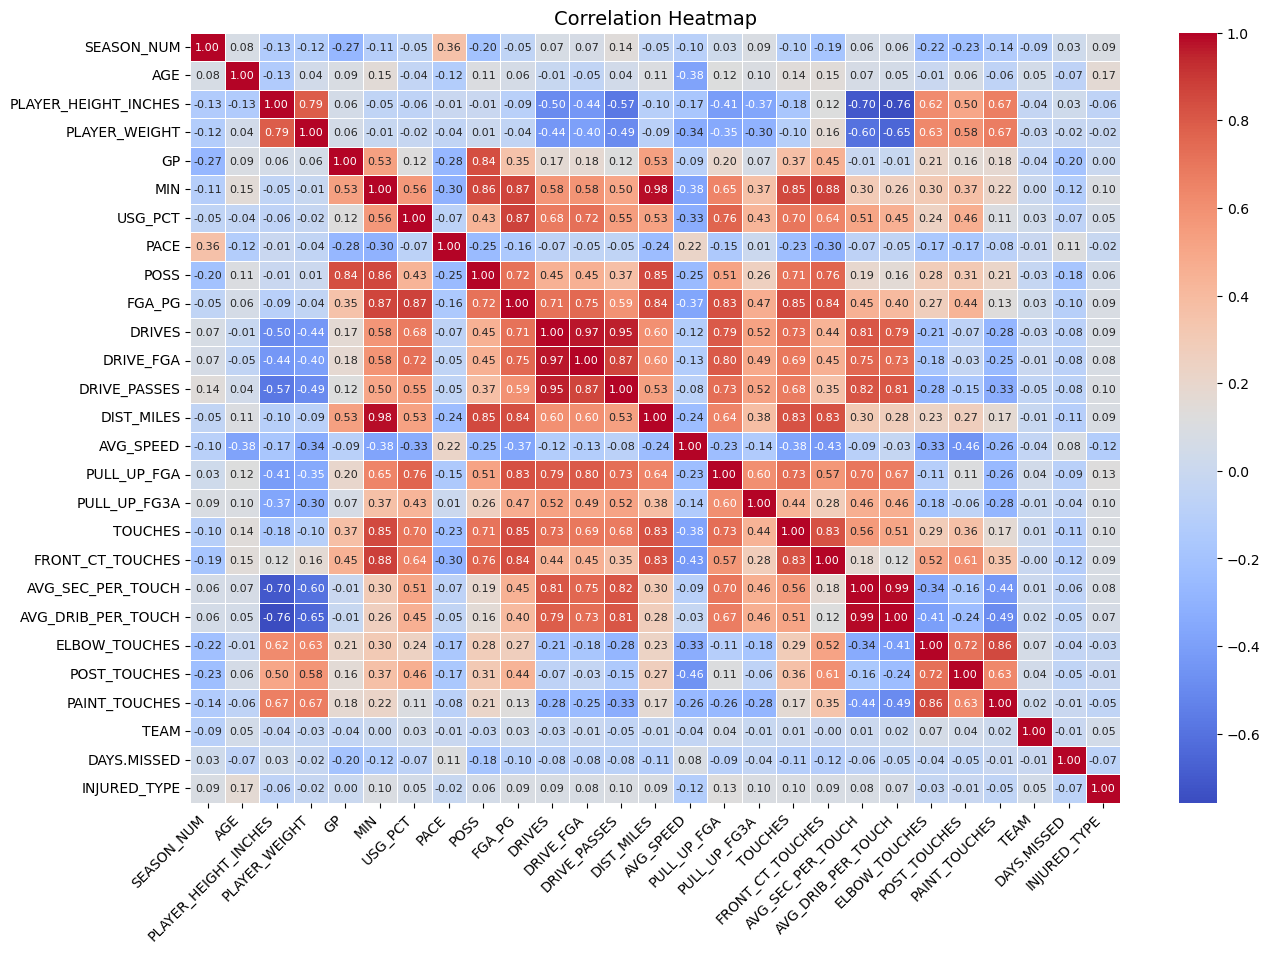

In [259]:
# Correlation Heatmap
plt.figure(figsize=(15,10))
corr_matrix = df.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, annot_kws={"size":8})
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.title('Correlation Heatmap', fontsize=14)
plt.show()

This correlation heatmap visualizes the relationships between various player statistics and injury-related factors, particularly days missed due to injury (DAYS.MISSED) and INJURED_TYPE. Strong positive correlations (red) indicate attributes that increase together, while negative correlations (blue) suggest an inverse relationship.

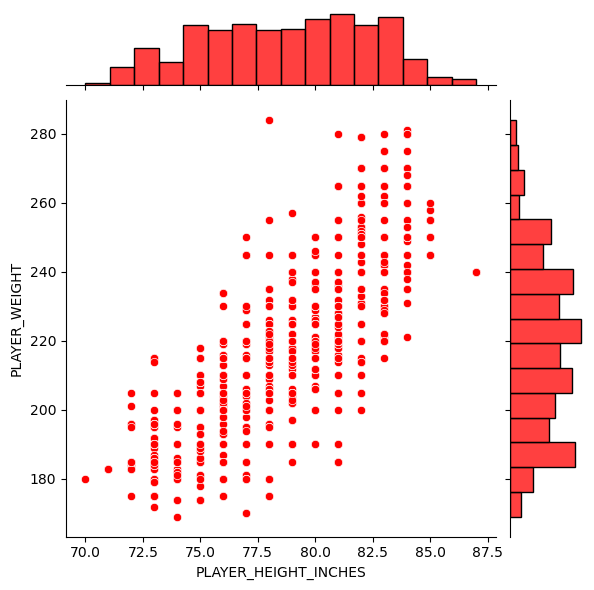

In [261]:
# Joint Plot: Height vs Weight
sns.jointplot(data=df, x='PLAYER_HEIGHT_INCHES', y='PLAYER_WEIGHT', kind='scatter', color='red')
plt.show()

This joint plot illustrates the relationship between player height and weight, showing a positive correlation, meaning taller players tend to weigh more. Findings: The distribution suggests that most NBA players fall between 75-85 inches in height and 200-260 lbs in weight, indicating a standard physique range for professional athletes

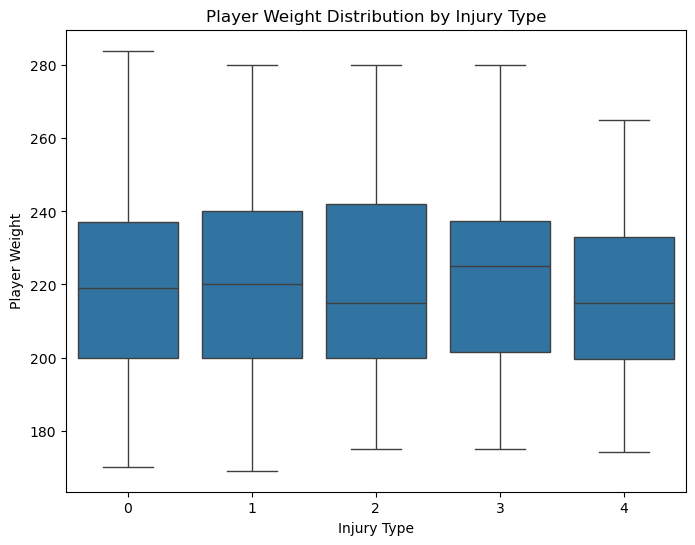

In [263]:
plt.figure(figsize=(8,6))
sns.boxplot(x=df['INJURED_TYPE'], y=df['PLAYER_WEIGHT'])
plt.title("Player Weight Distribution by Injury Type")
plt.xlabel("Injury Type")
plt.ylabel("Player Weight")
plt.show()

This box plot visualizes the distribution of player weight across different injury types, showing similar median weights across all injury categories. There is no strong correlation between player weight and specific injury types, suggesting that weight alone is not a major determinant of injury risk in NBA players.

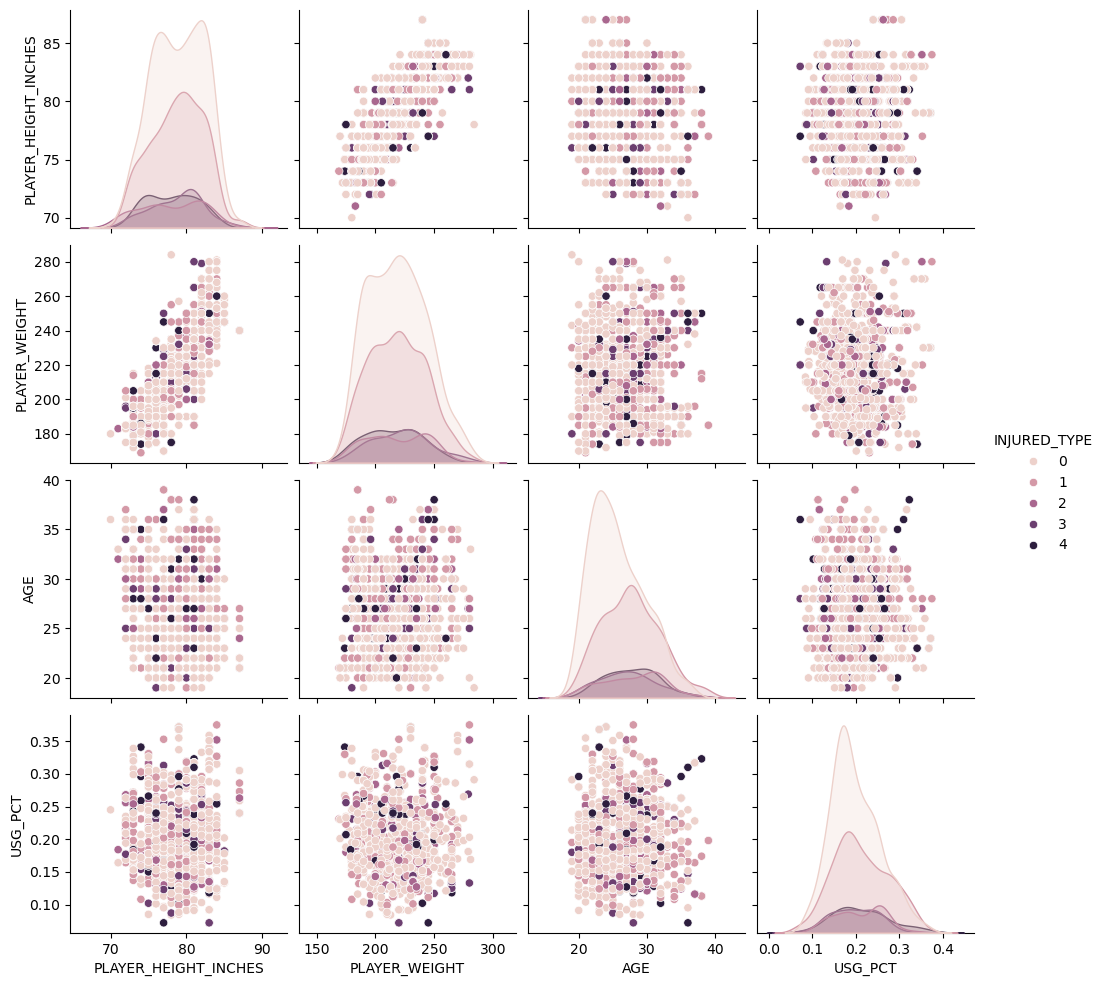

In [265]:
sns.pairplot(df, hue='INJURED_TYPE', vars=['PLAYER_HEIGHT_INCHES', 'PLAYER_WEIGHT', 'AGE', 'USG_PCT'])
plt.show()

This pair plot visualizes relationships between player attributes (height, weight, age, and usage percentage) and their injury types. There is no clear trend linking a single attribute to a specific injury type, but heavier and older players tend to have a wider spread of injury types, suggesting that multiple factors contribute to injury risk rather than just one physical attribute.

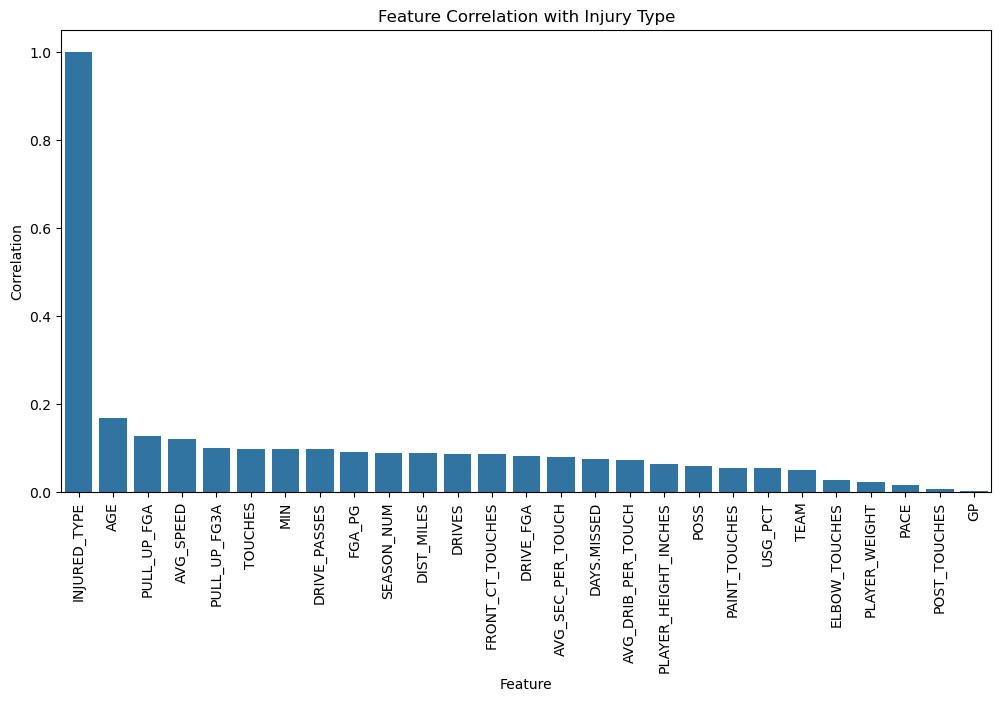

In [267]:
# 1. Key Factors Contributing to NBA Player Injuries
plt.figure(figsize=(12, 6))
sns.barplot(x=df.corr()['INJURED_TYPE'].abs().sort_values(ascending=False).index, 
            y=df.corr()['INJURED_TYPE'].abs().sort_values(ascending=False).values)
plt.xticks(rotation=90)
plt.title("Feature Correlation with Injury Type")
plt.xlabel("Feature")
plt.ylabel("Correlation")
plt.show()

This bar chart illustrates the correlation between various player statistics and injury type, highlighting the most influential features. Age, pull-up field goal attempts (PULL_UP_FGA), and average speed (AVG_SPEED) show the highest correlation with injury type, suggesting that older players and those with higher offensive workload and pace may be at greater risk of injuries.

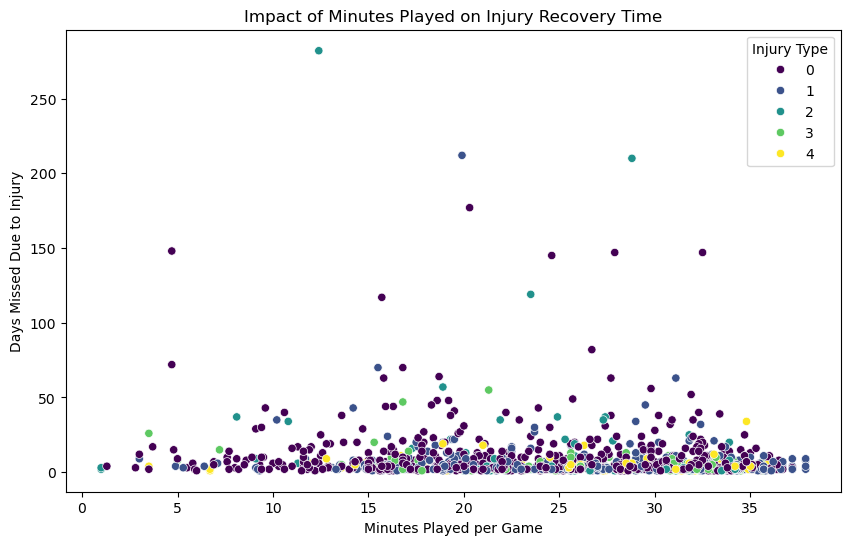

In [269]:
# Minutes Played vs. Days Missed
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='MIN', y='DAYS.MISSED', hue='INJURED_TYPE', palette='viridis')
plt.title("Impact of Minutes Played on Injury Recovery Time")
plt.xlabel("Minutes Played per Game")
plt.ylabel("Days Missed Due to Injury")
plt.legend(title="Injury Type")
plt.show()

This scatter plot examines the relationship between minutes played per game and injury recovery time (days missed) across different injury types. While most players miss only a few days regardless of minutes played, some outliers with lower playing time experience prolonged recovery, suggesting that factors beyond workload, such as injury severity or player condition, influence recovery time.

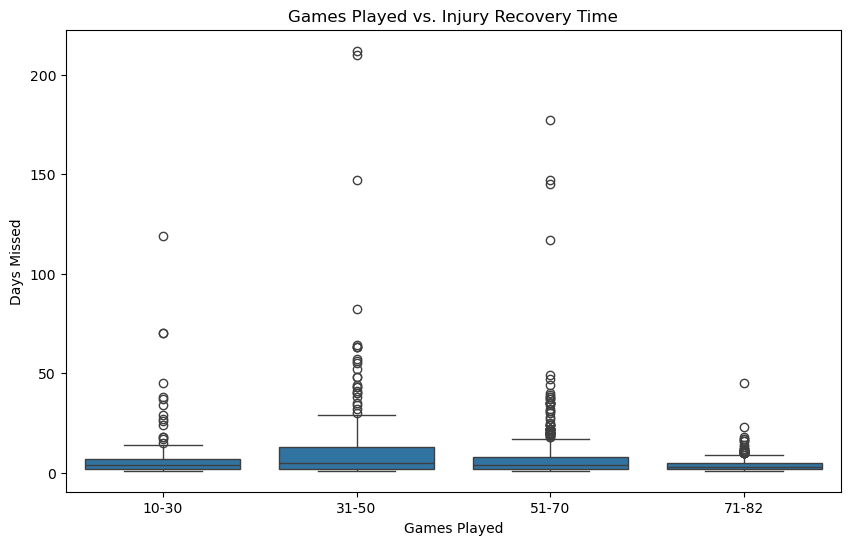

In [271]:
#3. Games Played vs. Days Missed
plt.figure(figsize=(10,6))
sns.boxplot(x=pd.cut(df['GP'], bins=[10, 30, 50, 70, 82], labels=['10-30', '31-50', '51-70', '71-82']), 
            y=df['DAYS.MISSED'])
plt.title("Games Played vs. Injury Recovery Time")
plt.xlabel("Games Played")
plt.ylabel("Days Missed")
plt.show()

This box plot compares the number of games played with days missed due to injury, helping analyze workload-related injury patterns. Players in the 10-50 games played range tend to have a higher variance in missed days, with several extreme outliers, suggesting that injuries leading to long recovery periods often limit a player's total games in a season.

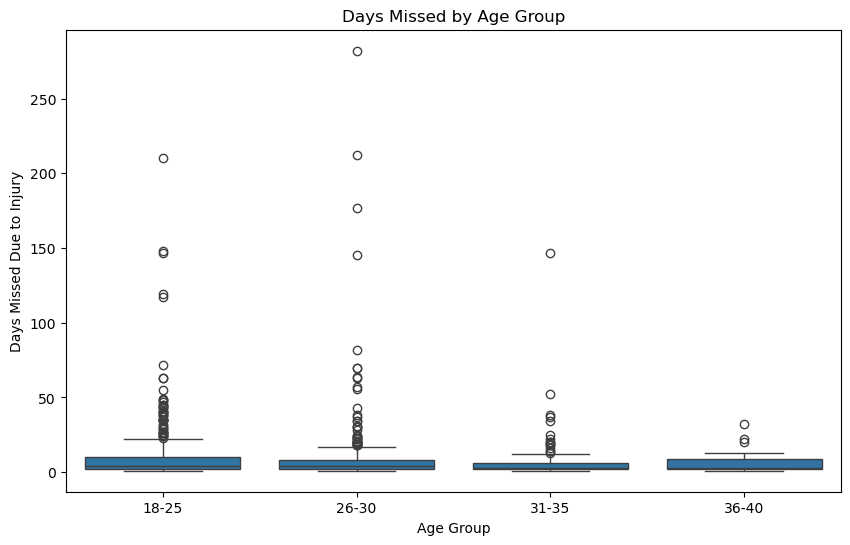

In [273]:
# 4.Age Group vs. Injury Severity
plt.figure(figsize=(10,6))
sns.boxplot(x=pd.cut(df['AGE'], bins=[18, 25, 30, 35, 40], labels=['18-25', '26-30', '31-35', '36-40']),
            y=df['DAYS.MISSED'])
plt.title("Days Missed by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Days Missed Due to Injury")
plt.show()

This box plot illustrates the relationship between age groups and days missed due to injury, highlighting differences in recovery time across age brackets. While all age groups show similar median days missed, younger players (18-30) exhibit more extreme outliers, suggesting that some severe injuries disproportionately affect younger athletes, potentially due to high-intensity play styles.

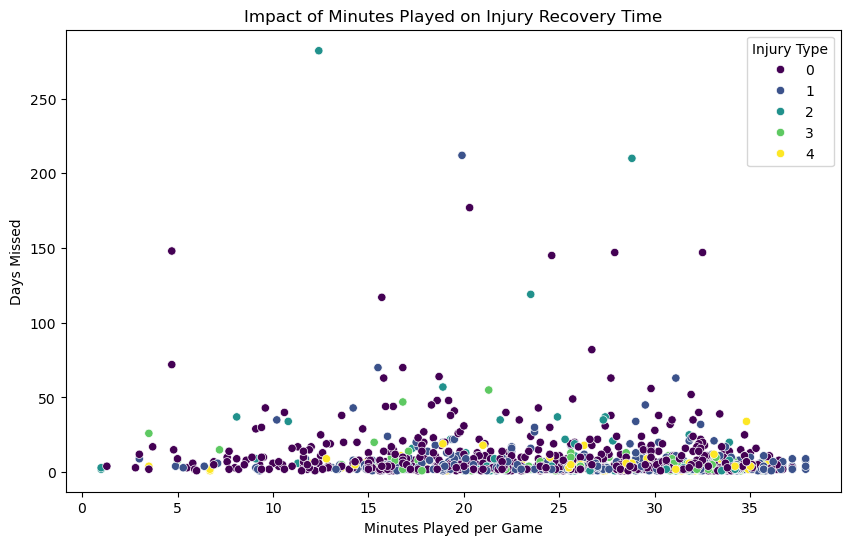

In [275]:
# 3. Workload Influence on Injury Risk: Minutes Played vs. Days Missed
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='MIN', y='DAYS.MISSED', hue=df['INJURED_TYPE'], palette='viridis')
plt.title("Impact of Minutes Played on Injury Recovery Time")
plt.xlabel("Minutes Played per Game")
plt.ylabel("Days Missed")
plt.legend(title="Injury Type")
plt.show()

This scatter plot examines the impact of minutes played per game on injury recovery time (days missed) across different injury types. While higher playing time does not directly correlate with longer recovery periods, a few outliers with moderate playing time (10-25 minutes) show significantly extended recovery, suggesting that injury severity rather than workload alone plays a key role in determining missed games.

### Handling Multicollinearity

In [278]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# Select only numerical features before splitting
X_numeric = df.select_dtypes(include=['float64', 'int64']).drop(columns=['INJURED_TYPE'])  # Drop target variable


In [279]:
# Compute VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X_numeric.columns
vif_data["VIF"] = [variance_inflation_factor(X_numeric.values, i) for i in range(len(X_numeric.columns))]

# Print features with high VIF
print(vif_data.sort_values(by="VIF", ascending=False))


                 Feature          VIF
2   PLAYER_HEIGHT_INCHES  1993.974649
5                    MIN  1567.416384
7                   PACE  1404.428603
13            DIST_MILES  1316.977328
14             AVG_SPEED  1053.757320
19     AVG_SEC_PER_TOUCH   438.942802
10                DRIVES   387.404304
3          PLAYER_WEIGHT   314.735544
9                 FGA_PG   275.942738
6                USG_PCT   215.735550
20    AVG_DRIB_PER_TOUCH   210.731933
0             SEASON_NUM   154.541858
11             DRIVE_FGA   135.185881
8                   POSS   131.375196
4                     GP   100.156504
12          DRIVE_PASSES    89.907261
18      FRONT_CT_TOUCHES    82.313307
17               TOUCHES    69.454736
1                    AGE    60.051247
15           PULL_UP_FGA    21.495967
23         PAINT_TOUCHES    12.145653
21         ELBOW_TOUCHES    11.632581
22          POST_TOUCHES     5.919257
16          PULL_UP_FG3A     4.298558
24                  TEAM     4.054020
25          

In [280]:
high_vif_features = ['MIN', 'DIST_MILES']
df = df.drop(columns=high_vif_features)

From the conclusion of Correlation matrix and Multicollinearit, Removing column 'MIN' and 'DIST_MILES'.

### Data Splitting and Scaling

In [283]:
# Splitting Data
X = df.drop(columns=['INJURED_TYPE'])
y = df['INJURED_TYPE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [284]:
# Scaling Features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Model Training and Evaluation

In [286]:
# Model Training
def train_and_evaluate(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.4f}')
    print(classification_report(y_test, y_pred))
    return model

#### Decision Tree

In [288]:
# Decision Tree
print("\nDecision Tree:")
dt = train_and_evaluate(DecisionTreeClassifier(random_state=42), X_train, X_test, y_train, y_test)



Decision Tree:
Accuracy: 0.4530
              precision    recall  f1-score   support

           0       0.57      0.56      0.57       112
           1       0.41      0.42      0.41        67
           2       0.37      0.64      0.47        11
           3       0.18      0.17      0.17        18
           4       0.28      0.19      0.23        26

    accuracy                           0.45       234
   macro avg       0.36      0.40      0.37       234
weighted avg       0.45      0.45      0.45       234



In [289]:
print("\nK-Nearest Neighbors (KNN):")
knn = train_and_evaluate(KNeighborsClassifier(n_neighbors=5), X_train, X_test, y_train, y_test)



K-Nearest Neighbors (KNN):
Accuracy: 0.5214
              precision    recall  f1-score   support

           0       0.57      0.79      0.66       112
           1       0.41      0.36      0.38        67
           2       0.45      0.45      0.45        11
           3       1.00      0.06      0.11        18
           4       0.43      0.12      0.18        26

    accuracy                           0.52       234
   macro avg       0.57      0.36      0.36       234
weighted avg       0.54      0.52      0.48       234



#### Random Forest

In [291]:
# Random Forest
print("\nRandom Forest:")
rf = train_and_evaluate(RandomForestClassifier(random_state=42), X_train, X_test, y_train, y_test)


Random Forest:
Accuracy: 0.5427
              precision    recall  f1-score   support

           0       0.58      0.80      0.68       112
           1       0.42      0.37      0.40        67
           2       0.86      0.55      0.67        11
           3       0.60      0.17      0.26        18
           4       0.33      0.12      0.17        26

    accuracy                           0.54       234
   macro avg       0.56      0.40      0.43       234
weighted avg       0.52      0.54      0.51       234



### Handling Imbalanced Data using SMOTE

In [293]:
# Apply SMOTE to balance the dataset
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# Print the new class distribution
from collections import Counter
print("Class distribution after SMOTE:", Counter(y_train_bal))


Class distribution after SMOTE: Counter({0: 453, 4: 453, 1: 453, 2: 453, 3: 453})


### Applying Hyper parameter tuning for Random Forest after handling imbalanced data using SMOT

In [295]:
# Define hyperparameter tuning for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform GridSearchCV to find best parameters for Random Forest
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(X_train_bal, y_train_bal)

# Best parameters
best_rf_params = grid_search_rf.best_params_
print("Best Random Forest Parameters:", best_rf_params)

# Train optimized Random Forest model
best_rf = RandomForestClassifier(**best_rf_params, random_state=42)
best_rf.fit(X_train_bal, y_train_bal)

# Evaluate the model
y_pred_rf = best_rf.predict(X_test)

# Print evaluation metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
classification_rep_rf = classification_report(y_test, y_pred_rf)

print(f"Optimized Random Forest Accuracy: {accuracy_rf:.4f}")
print("Classification Report:\n", classification_rep_rf)

Best Random Forest Parameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Optimized Random Forest Accuracy: 0.5299
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.71      0.67       112
           1       0.41      0.37      0.39        67
           2       0.46      0.55      0.50        11
           3       0.40      0.22      0.29        18
           4       0.39      0.35      0.37        26

    accuracy                           0.53       234
   macro avg       0.46      0.44      0.44       234
weighted avg       0.51      0.53      0.52       234



### Trying smote to other models

### Support Vector Machines (SVM)

In [298]:

svm = SVC(kernel='rbf', C=1, gamma='scale', random_state=42)
svm.fit(X_train_bal, y_train_bal)

y_pred_svm = svm.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))


SVM Accuracy: 0.4444444444444444
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.48      0.54       112
           1       0.49      0.45      0.47        67
           2       0.22      0.55      0.32        11
           3       0.21      0.22      0.22        18
           4       0.25      0.38      0.30        26

    accuracy                           0.44       234
   macro avg       0.36      0.42      0.37       234
weighted avg       0.49      0.44      0.46       234



### KNN

In [300]:
# Train K-Nearest Neighbors (KNN) model
knn = KNeighborsClassifier(n_neighbors=5)  # You can change the value of 'n_neighbors' for better performance
knn.fit(X_train_bal, y_train_bal)

# Predict on test data
y_pred_knn = knn.predict(X_test)

# Evaluate the model
print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))
print("KNN Classification Report:\n", classification_report(y_test, y_pred_knn))

KNN Accuracy: 0.3547008547008547
KNN Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.30      0.40       112
           1       0.39      0.37      0.38        67
           2       0.23      0.64      0.34        11
           3       0.21      0.39      0.27        18
           4       0.20      0.38      0.26        26

    accuracy                           0.35       234
   macro avg       0.33      0.42      0.33       234
weighted avg       0.45      0.35      0.37       234



### Hyper parameter tuning for best model( Default random forest with no SMOTE)

In [302]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees
    'max_depth': [10, 20, 30],        # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4]     # Minimum samples required in a leaf node
}

# Initialize GridSearchCV
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), 
                           param_grid, 
                           cv=5,  # 5-fold cross-validation
                           scoring='accuracy', 
                           n_jobs=-1,  # Use all available cores
                           verbose=1)

# Perform grid search
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Hyperparameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}


In [303]:
# Train optimized Random Forest model
best_rf = RandomForestClassifier(**best_params, random_state=42)
best_rf.fit(X_train, y_train)

# Evaluate the model
y_pred_rf = best_rf.predict(X_test)

# Print evaluation metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
classification_rep_rf = classification_report(y_test, y_pred_rf)

print(f"Optimized Random Forest Accuracy: {accuracy_rf:.4f}")
print("Classification Report:\n", classification_rep_rf)


Optimized Random Forest Accuracy: 0.5726
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.82      0.70       112
           1       0.48      0.45      0.46        67
           2       0.86      0.55      0.67        11
           3       0.50      0.11      0.18        18
           4       0.44      0.15      0.23        26

    accuracy                           0.57       234
   macro avg       0.58      0.42      0.45       234
weighted avg       0.56      0.57      0.54       234



In [304]:
# Default Random Forest (without tuning)
rf_default = RandomForestClassifier(random_state=42)
rf_default.fit(X_train, y_train)

y_pred_default = rf_default.predict(X_test)
accuracy_default = accuracy_score(y_test, y_pred_default)

print(f"Default RF Accuracy: {accuracy_default:.4f}")
print(f"Optimized RF Accuracy: {accuracy_rf:.4f}")


Default RF Accuracy: 0.5427
Optimized RF Accuracy: 0.5726


#### Hyper parameter tuning of default randomforest with RandomizedSearchCV

In [306]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define RandomizedSearch parameter grid
random_grid = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(10, 50),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 4)
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(RandomForestClassifier(random_state=42), 
                                   param_distributions=random_grid, 
                                   n_iter=20,  # Number of random combinations
                                   cv=5, 
                                   scoring='accuracy', 
                                   n_jobs=-1, 
                                   verbose=1)

# Perform Randomized Search
random_search.fit(X_train, y_train)

# Get best parameters
best_params_random = random_search.best_params_
print("Best Hyperparameters (Randomized Search):", best_params_random)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Hyperparameters (Randomized Search): {'max_depth': 27, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 302}


In [307]:
# Train the optimized Random Forest model
best_rf = RandomForestClassifier(**best_params_random, random_state=42)
best_rf.fit(X_train, y_train)

# Predict on test set
y_pred_rf = best_rf.predict(X_test)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
classification_rep_rf = classification_report(y_test, y_pred_rf)
conf_matrix = confusion_matrix(y_test, y_pred_rf)

# Print evaluation metrics
print("\n Classification Report:\n", classification_rep_rf)
print("\n Confusion Matrix:\n", conf_matrix)


 Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.81      0.69       112
           1       0.48      0.45      0.46        67
           2       0.86      0.55      0.67        11
           3       0.50      0.11      0.18        18
           4       0.44      0.15      0.23        26

    accuracy                           0.57       234
   macro avg       0.58      0.41      0.45       234
weighted avg       0.55      0.57      0.53       234


 Confusion Matrix:
 [[91 16  0  1  4]
 [34 30  1  1  1]
 [ 1  4  6  0  0]
 [12  4  0  2  0]
 [13  9  0  0  4]]


The final model, Random Forest (Optimized without SMOTE), achieved 57% accuracy, making it the best-performing model for NBA injury risk prediction. Key insights indicate that age, pull-up field goal attempts, and average speed significantly impact injury risk.